<a href="https://colab.research.google.com/github/hardikjh/BLASC/blob/main/BLASC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from __future__ import print_function
import datetime, time, json
import itertools
import pickle


from keras.models import Model
from keras.layers import Input, Bidirectional, LSTM, dot, Flatten, Dense, Reshape, add, Dropout, BatchNormalization
from keras.layers.embeddings import Embedding
from keras.regularizers import l2
from keras.callbacks import Callback, ModelCheckpoint
from keras import backend as K

TensorFlow 1.x selected.


Using TensorFlow backend.


In [ ]:
# Structuring data in tabular form
_a=pd.read_table('data/appl_pair_shuffle.fa', sep='>', names=('A', 'B'))
_b=pd.concat([_a['A'].dropna().reset_index(drop=True), _a['B'].dropna().reset_index(drop=True)], axis=1)
right=_b.iloc[1::2].reset_index(drop=True)
left=_b.iloc[::2].reset_index(drop=True)
left_right_df=pd.merge(left, right, on='B').rename(columns={'A_x':'left','A_y':'right','B':'id'})

In [ ]:
# left & right columns have respective sequences for which distance will be calculated. id has respective sequence ID's which are to be compared
left_right_df

,left,id,right
0,atgacccaccaagctcatgcataccacatagtagaccccagccctt...,seq118-seq166,atggccagccttcggaaaacccacccaatcctaaaaattgctaatg...
1,atgagtctaattataactattatagcaatttcatcggcgttatcga...,seq31-seq230,atgcatagcatccctttactctacacttcaagccttttgttaatac...
2,atgatactaagcttctttgaccagtttataagcccctcatacctag...,seq72-seq3,atgacccccactcactttacaatttcctcagcctttctgttaggta...
3,atgctaaaaatcctaattcctactttatttcttctcccaacaacct...,seq200-seq182,atgctaaaaattcttattcctactttatttcttctcccaacaacct...
4,atgctaaaaatcctaattcctactttatttcttctcccaacaacct...,seq200-seq182,atgctaaaaattcttattcctactttatttcttctcccaacaacct...
...,...,...,...
69559,gacctccatattactgaaaggaagccaaaagggatcaattaagtgc...,Amplicon_216-Amplicon_746,acacgtcttcaaagcaagtggattgatgagatatctccactgacgt...
69560,agatctcctgtcatctcaccttgctcctgccgagaaaagtatccat...,Amplicon_829-Amplicon_291,ttagcctcccgctgcagagcggcagtgtggttggtttcttcgaacg...
69561,cgcggtttctgatatcgttaaccattacattgagacgtctacagtg...,Amplicon_469-Amplicon_615,ggatctcctgtcatctcaccttgctcctgccgagaaagtatccatc...
69562,ccacgtcttcaaagcaagtggattgatgtgatatctccactgacgt...,Amplicon_440-Amplicon_50,gaatcctgttgccggtcttgcgatgattatcatataatttctgttg...


In [ ]:
left_right_df=left_right_df[~left_right_df.left.str.contains("r", regex=False)]
left_right_df=left_right_df[~left_right_df.right.str.contains("r", regex=False)]

In [ ]:
distance_df=pd.read_table('../MTP_data/appl_dist_shuffle.txt', sep='\t', names=('id', 'distance'))
final_df=pd.merge(left_right_df, distance_df, on='id')

In [ ]:
final_df=final_df.drop_duplicates()

In [ ]:
#dataframe with sequences and target value (distance)
final_df

,left,id,right,distance
0,atgacccaccaagctcatgcataccacatagtagaccccagccctt...,seq118-seq166,atggccagccttcggaaaacccacccaatcctaaaaattgctaatg...,0.5395
1,atgagtctaattataactattatagcaatttcatcggcgttatcga...,seq31-seq230,atgcatagcatccctttactctacacttcaagccttttgttaatac...,0.5987
2,atgatactaagcttctttgaccagtttataagcccctcatacctag...,seq72-seq3,atgacccccactcactttacaatttcctcagcctttctgttaggta...,0.5473
3,atgctaaaaatcctaattcctactttatttcttctcccaacaacct...,seq200-seq182,atgctaaaaattcttattcctactttatttcttctcccaacaacct...,0.1523
11,atggcacacccctcacaactaggattccaagacgcggcatcacccg...,seq87-seq140,atggcccacgttgtgattagttatattcttaaccccctcatttata...,0.5801
...,...,...,...,...
99563,gacctccatattactgaaaggaagccaaaagggatcaattaagtgc...,Amplicon_216-Amplicon_746,acacgtcttcaaagcaagtggattgatgagatatctccactgacgt...,0.5855
99564,agatctcctgtcatctcaccttgctcctgccgagaaaagtatccat...,Amplicon_829-Amplicon_291,ttagcctcccgctgcagagcggcagtgtggttggtttcttcgaacg...,0.6964
99565,cgcggtttctgatatcgttaaccattacattgagacgtctacagtg...,Amplicon_469-Amplicon_615,ggatctcctgtcatctcaccttgctcctgccgagaaagtatccatc...,0.6398
99566,ccacgtcttcaaagcaagtggattgatgtgatatctccactgacgt...,Amplicon_440-Amplicon_50,gaatcctgttgccggtcttgcgatgattatcatataatttctgttg...,0.6190


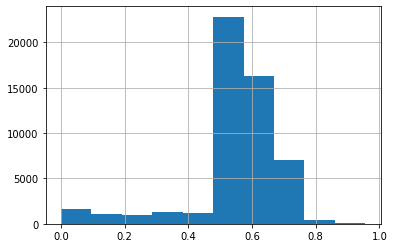

In [ ]:
final_df.distance.hist()

In [ ]:
final_df.reset_index(drop=True,inplace=True)

In [ ]:
vocabulary = {'a':1,'g':2,'c':3,'t':4}

final_df['left']=final_df['left'].apply(lambda x: [vocabulary[nucleotide] for nucleotide in list(x)])
final_df['right']=final_df['right'].apply(lambda x: [vocabulary[nucleotide] for nucleotide in list(x)])
final_df.head()

,left,id,right,distance
0,"[1, 4, 2, 1, 3, 3, 3, 1, 3, 3, 1, 1, 2, 3, 4, ...",seq118-seq166,"[1, 4, 2, 2, 3, 3, 1, 2, 3, 3, 4, 4, 3, 2, 2, ...",0.5395
1,"[1, 4, 2, 1, 2, 4, 3, 4, 1, 1, 4, 4, 1, 4, 1, ...",seq31-seq230,"[1, 4, 2, 3, 1, 4, 1, 2, 3, 1, 4, 3, 3, 3, 4, ...",0.5987
2,"[1, 4, 2, 1, 4, 1, 3, 4, 1, 1, 2, 3, 4, 4, 3, ...",seq72-seq3,"[1, 4, 2, 1, 3, 3, 3, 3, 3, 1, 3, 4, 3, 1, 3, ...",0.5473
3,"[1, 4, 2, 3, 4, 1, 1, 1, 1, 1, 4, 3, 3, 4, 1, ...",seq200-seq182,"[1, 4, 2, 3, 4, 1, 1, 1, 1, 1, 4, 4, 3, 4, 4, ...",0.1523
4,"[1, 4, 2, 2, 3, 1, 3, 1, 3, 3, 3, 3, 4, 3, 1, ...",seq87-seq140,"[1, 4, 2, 2, 3, 3, 3, 1, 3, 2, 4, 4, 2, 4, 2, ...",0.5801


In [ ]:
scaler = MinMaxScaler()
final_df.distance=pd.DataFrame(scaler.fit_transform(final_df.distance.values.reshape(-1,1)), columns=['distance'])

In [ ]:
#creating a pickle for scaler to be used later (for generating Bootstrap trees)
with open('../MTP_data/Bootstrap/applications_scaler.pickle', 'wb') as f:
    pickle.dump(scaler, f)


In [ ]:
#Creating embedding matrix

sequence_cols = ['left', 'right']
           
embedding_dim = 4
embeddings = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim)  # This will be the embedding matrix
embeddings[0] = 0  # So that the padding will be ignored

embeddings[1]=[1,0,0,0]
embeddings[2]=[0,1,0,0]
embeddings[3]=[0,0,1,0]
embeddings[4]=[0,0,0,1]

In [ ]:
embeddings

array([[0., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

# + Preparing **training** and **validation** datasets

In [ ]:
train_df = final_df

train_df.left.str.len().max()
max_seq_length = train_df.left.str.len().max()

In [ ]:
# Split to train validation
validation_size = int(52700*0.3)
training_size = len(train_df) - validation_size

X = train_df[sequence_cols]
Y = train_df['distance']

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size)

# Split to dicts
X_train = {'left': X_train.left, 'right': X_train.right}
X_validation = {'left': X_validation.left, 'right': X_validation.right}

# Convert labels to their numpy representations
Y_train = Y_train.values
Y_validation = Y_validation.values

# Zero padding
for dataset, side in itertools.product([X_train, X_validation], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)

In [ ]:
X_train['left'][9].shape

(358,)

# BLASC **Model**

In [ ]:
#model hyperparameters
EMBEDDING_DIM = 12
MAX_SEQUENCE_LENGTH=max_seq_length
DROPOUT = 0.35
NB_EPOCHS=30
BATCH_SIZE=100

#defining model
left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')

embedding_layer = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=max_seq_length, trainable=False)
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

q1 = Bidirectional(LSTM(EMBEDDING_DIM, return_sequences=True), merge_mode="sum")(encoded_left)

q2 = Bidirectional(LSTM(EMBEDDING_DIM, return_sequences=True), merge_mode="sum")(encoded_right)

attention = dot([q1,q2], [1,1])
attention = Flatten()(attention)
attention = Dense((MAX_SEQUENCE_LENGTH*EMBEDDING_DIM))(attention)
attention = Reshape((MAX_SEQUENCE_LENGTH, EMBEDDING_DIM))(attention)

merged = add([q1,attention])
merged = Flatten()(merged)
merged = Dense(50, activation='relu')(merged)
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)
merged = Dense(50, activation='relu')(merged)
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)

is_duplicate = Dense(1, activation='elu')(merged)

model = Model(inputs=[left_input,right_input], outputs=is_duplicate)
model.compile(loss='mean_squared_error', optimizer='Nadam', metrics=['mae'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
print("Starting training at", datetime.datetime.now())
t0 = time.time()

history = model.fit([X_train['left'], X_train['right']],
                    Y_train,
                    epochs=NB_EPOCHS,
                    validation_split=0.1,
                    verbose=2,
                    batch_size=BATCH_SIZE)

t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2020-05-28 15:08:17.852272

Train on 33203 samples, validate on 3690 samples
Epoch 1/30
 - 81s - loss: 0.2175 - mae: 0.3130 - val_loss: 0.0206 - val_mae: 0.0962
Epoch 2/30
 - 78s - loss: 0.0214 - mae: 0.0962 - val_loss: 0.0198 - val_mae: 0.0886
Epoch 3/30
 - 79s - loss: 0.0198 - mae: 0.0882 - val_loss: 0.0193 - val_mae: 0.0897
Epoch 4/30
 - 87s - loss: 0.0192 - mae: 0.0879 - val_loss: 0.0223 - val_mae: 0.1005
Epoch 5/30
 - 89s - loss: 0.0193 - mae: 0.0876 - val_loss: 0.0193 - val_mae: 0.0761
Epoch 6/30
 - 100s - loss: 0.0186 - mae: 0.0858 - val_loss: 0.0183 - val_mae: 0.0819
Epoch 7/30
 - 98s - loss: 0.0170 - mae: 0.0840 - val_loss: 0.0196 - val_mae: 0.1161
Epoch 8/30
 - 97s - loss: 0.0127 - mae: 0.0739 - val_loss: 0.0093 - val_mae: 0.0656
Epoch 9/30
 - 100s - loss: 0.0108 - mae: 0.0676 - val_loss: 0.0128 - val_mae: 0.0951
Epoch 10/30
 - 96s - loss: 0.0087 - mae: 0.0602 - val_loss: 0.0076 - val_mae: 0.0548
Epoch 11/30
 - 99s - loss: 0.0087 - mae: 0.0603 - val_loss:

In [ ]:
# import pickle
# with open('applications_model.pickle', 'wb') as f:
#     # Pickle the 'data' dictionary using the highest protocol available.
#     pickle.dump(model, f)